<h1><center>Введение в анализ данных</center></h1>
<hr>
<h2><center>Quora Question Pairs</center></h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.linear_model import LinearRegression, Ridge
#from sklearn.preprocessing import StandardScaler
#from sklearn.svm import SVR

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

<h2>Подготовка данных:</h2>

<h3>Основная таблица</h3>

In [2]:
#filepath = '/media/ivan/Acer/Ivan/sphere/Quora/train.csv'
filepath = 'C:\Ivan\sphere\Quora\\train.csv'
df = pd.read_csv(filepath, sep=',')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
df = df.reset_index(drop=True)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Доля дублирующихся вопросов

In [4]:
df.is_duplicate.mean()

0.369197853026293

<h2>Формат выходных данных</h2>

In [5]:
#filepath = '/media/ivan/Acer/Ivan/sphere/Quora/sample_submission.csv'
filepath = 'C:\Ivan\sphere\Quora\\sample_submission.csv'
df_out = pd.read_csv(filepath, sep=',')
print len(df_out)
df_out.head()

2345796


,test_id,is_duplicate
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


<h2>Shallow benchmark</h2>

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [16]:
df = df.dropna(how='any')

In [13]:
BOW = CountVectorizer(max_df=0.999, min_df=1000, max_features=300, 
                                      analyzer='char', ngram_range=(1,2), 
                                      binary=True, lowercase=True)

In [14]:
BOW

CountVectorizer(analyzer='char', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.999, max_features=300, min_df=1000,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [17]:
BOW.fit(pd.concat((df.ix[:,'question1'],df.ix[:,'question2'])).unique())

CountVectorizer(analyzer='char', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.999, max_features=300, min_df=1000,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [18]:
BOWq1 = BOW.transform(df.ix[:,'question1'])

In [19]:
BOWq2 = BOW.transform(df.ix[:,'question2'])

In [20]:
labels = df.is_duplicate.values

In [25]:
from sklearn import model_selection
from sklearn import linear_model

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
import time

In [28]:
crossValidationStartTime = time.time()

numCVSplits = 8
numSplitsToBreakAfter = 2

X = -(BOWq1 != BOWq2).astype(int)
#X = -(trainQuestion1_BOW_rep != trainQuestion2_BOW_rep).astype(int) + \
#      trainQuestion1_BOW_rep.multiply(trainQuestion2_BOW_rep)
y = labels

logisticRegressor = linear_model.LogisticRegression(C=0.1, solver='sag')

logRegAccuracy = []
logRegLogLoss = []
logRegAUC = []

print('---------------------------------------------')
stratifiedCV = model_selection.StratifiedKFold(n_splits=numCVSplits, random_state=2)
for k, (trainInds, validInds) in enumerate(stratifiedCV.split(X, y)):
    foldTrainingStartTime = time.time()

    X_train_cv = X[trainInds,:]
    X_valid_cv = X[validInds,:]

    y_train_cv = y[trainInds]
    y_valid_cv = y[validInds]

    logisticRegressor.fit(X_train_cv, y_train_cv)

    y_train_hat =  logisticRegressor.predict_proba(X_train_cv)[:,1]
    y_valid_hat =  logisticRegressor.predict_proba(X_valid_cv)[:,1]

    logRegAccuracy.append(accuracy_score(y_valid_cv, y_valid_hat > 0.5))
    logRegLogLoss.append(log_loss(y_valid_cv, y_valid_hat))
    logRegAUC.append(roc_auc_score(y_valid_cv, y_valid_hat))
    
    foldTrainingDurationInMinutes = (time.time()-foldTrainingStartTime)/60.0
    print('fold %d took %.2f minutes: accuracy = %.3f, log loss = %.4f, AUC = %.3f' % (k+1,
             foldTrainingDurationInMinutes, logRegAccuracy[-1],logRegLogLoss[-1],logRegAUC[-1]))

    if (k+1) >= numSplitsToBreakAfter:
        break


crossValidationDurationInMinutes = (time.time()-crossValidationStartTime)/60.0

print('---------------------------------------------')
print('cross validation took %.2f minutes' % (crossValidationDurationInMinutes))
print('mean CV: accuracy = %.3f, log loss = %.4f, AUC = %.3f' % (np.array(logRegAccuracy).mean(),
                                                                 np.array(logRegLogLoss).mean(),
                                                                 np.array(logRegAUC).mean()))
print('---------------------------------------------')

---------------------------------------------
fold 1 took 0.20 minutes: accuracy = 0.713, log loss = 0.5262, AUC = 0.786
fold 2 took 0.17 minutes: accuracy = 0.712, log loss = 0.5289, AUC = 0.783
---------------------------------------------
cross validation took 0.39 minutes
mean CV: accuracy = 0.713, log loss = 0.5276, AUC = 0.785
---------------------------------------------


In [30]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

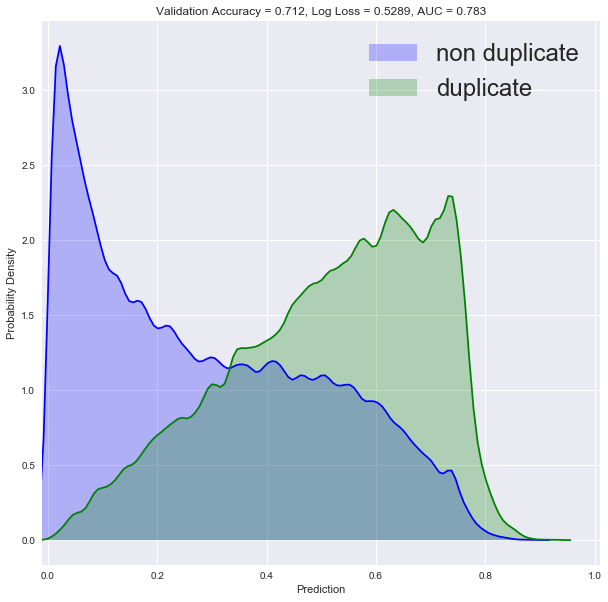

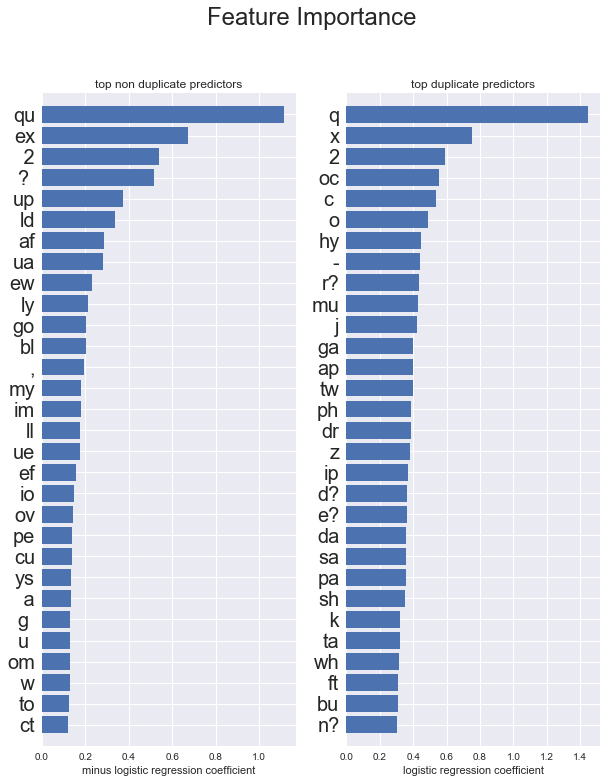

In [32]:
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.figure(); 
sns.kdeplot(y_valid_hat[y_valid_cv==0], shade=True, color="b", bw=0.01)
sns.kdeplot(y_valid_hat[y_valid_cv==1], shade=True, color="g", bw=0.01)
plt.legend(['non duplicate','duplicate'],fontsize=24)
plt.title('Validation Accuracy = %.3f, Log Loss = %.4f, AUC = %.3f' %(logRegAccuracy[-1],
                                                                      logRegLogLoss[-1],
                                                                      logRegAUC[-1]))
plt.xlabel('Prediction'); plt.ylabel('Probability Density'); plt.xlim(-0.01,1.01)


numFeaturesToShow = 30

sortedCoeffients = np.sort(logisticRegressor.coef_)[0]
featureNames = BOW.get_feature_names()
sortedFeatureNames = [featureNames[x] for x in list(np.argsort(logisticRegressor.coef_)[0])]

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,12)

plt.figure()
plt.suptitle('Feature Importance',fontsize=24)
ax = plt.subplot(1,2,1); plt.title('top non duplicate predictors'); 
plt.xlabel('minus logistic regression coefficient')
ax.barh(range(numFeaturesToShow), -sortedCoeffients[:numFeaturesToShow][::-1], align='center'); 
plt.ylim(-1,numFeaturesToShow); ax.set_yticks(range(numFeaturesToShow)); 
ax.set_yticklabels(sortedFeatureNames[:numFeaturesToShow][::-1],fontsize=20)

ax = plt.subplot(1,2,2); plt.title('top duplicate predictors'); 
plt.xlabel('logistic regression coefficient')
ax.barh(range(numFeaturesToShow), sortedCoeffients[-numFeaturesToShow:], align='center'); 
plt.ylim(-1,numFeaturesToShow); ax.set_yticks(range(numFeaturesToShow)); 
ax.set_yticklabels(sortedFeatureNames[-numFeaturesToShow:],fontsize=20)

In [33]:
trainingStartTime = time.time()

logisticRegressor = linear_model.LogisticRegression(C=0.1, solver='sag', 
                                                    class_weight={1: 0.46, 0: 1.32})
logisticRegressor.fit(X, y)

trainingDurationInMinutes = (time.time()-trainingStartTime)/60.0
print('full training took %.2f minutes' % (trainingDurationInMinutes))

full training took 0.18 minutes


predicting on test took 17.71 minutes


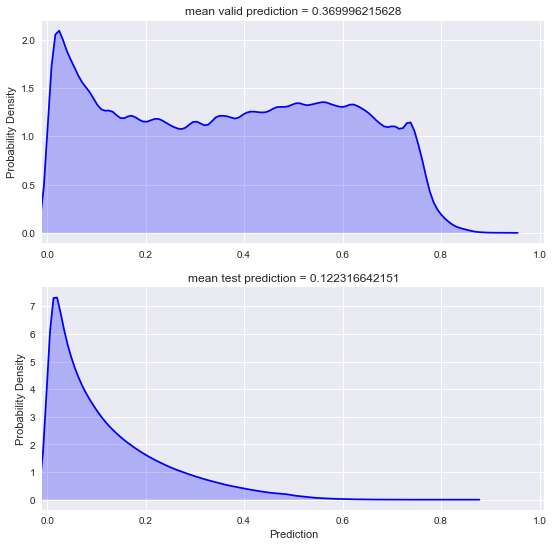

In [35]:
testPredictionStartTime = time.time()

filepath = 'C:\Ivan\sphere\Quora\\test.csv'
testDF = pd.read_csv(filepath)
testDF.ix[testDF['question1'].isnull(),['question1','question2']] = 'random empty question'
testDF.ix[testDF['question2'].isnull(),['question1','question2']] = 'random empty question'

testQuestion1_BOW_rep = BOW.transform(testDF.ix[:,'question1'])
testQuestion2_BOW_rep = BOW.transform(testDF.ix[:,'question2'])

X_test = -(testQuestion1_BOW_rep != testQuestion2_BOW_rep).astype(int)
#X_test = -(testQuestion1_BOW_rep != testQuestion2_BOW_rep).astype(int) + \
#           testQuestion1_BOW_rep.multiply(testQuestion2_BOW_rep)

#testPredictions = logisticRegressor.predict_proba(X_test)[:,1]

# quick fix to avoid memory errors
seperators= [750000,1500000]
testPredictions1 = logisticRegressor.predict_proba(X_test[:seperators[0],:])[:,1]
testPredictions2 = logisticRegressor.predict_proba(X_test[seperators[0]:seperators[1],:])[:,1]
testPredictions3 = logisticRegressor.predict_proba(X_test[seperators[1]:,:])[:,1]
testPredictions = np.hstack((testPredictions1,testPredictions2,testPredictions3))

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9,9)

plt.figure(); 
plt.subplot(2,1,1); sns.kdeplot(y_valid_hat, shade=True, color="b", bw=0.01); 
plt.ylabel('Probability Density'); plt.xlim(-0.01,1.01)
plt.title('mean valid prediction = ' + str(np.mean(y_valid_hat)))
plt.subplot(2,1,2); sns.kdeplot(testPredictions, shade=True, color="b", bw=0.01);
plt.xlabel('Prediction'); plt.ylabel('Probability Density'); plt.xlim(-0.01,1.01)
plt.title('mean test prediction = ' + str(np.mean(testPredictions)))

testPredictionDurationInMinutes = (time.time()-testPredictionStartTime)/60.0
print('predicting on test took %.2f minutes' % (testPredictionDurationInMinutes))

In [36]:
#filepath = '/media/ivan/Acer/Ivan/sphere/Quora/quora.csv'
filepath = 'C:\Ivan\sphere\Quora\\shallowBenchmark.csv'

submission = pd.DataFrame()
submission['test_id'] = testDF['test_id']
submission['is_duplicate'] = testPredictions
submission.to_csv(filepath, index=False)

In [1]:
#0.38796